In [1]:
import yaml
import os
import numpy as np
import autokeras as ak #Necessary to import otherwise load_model does not work
from tensorflow.keras.models import load_model
from dti_util import default, stack_training, unstack_training, clean_ax

import matplotlib.pyplot as plt
import glob
import matplotlib as mpl
from tqdm.notebook import tqdm
import matplotlib.gridspec as gridspec

# Change default matplotlib
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['savefig.pad_inches']=0.1
mpl.rcParams['axes.labelsize']=mpl.rcParams['axes.titlesize']
plt.rcParams['savefig.facecolor']='white'

In [2]:
# Name of the experiment to use
# Modify this cell to change the experiment between passive microwave or SAR input
exp_type = 'pmw' #Passive microwave case
#exp_type = 'sar' #SAR type


In [3]:
if exp_type == 'sar': #Input SAR deformation
    #Name of the experiment
    name = 'exp-sr-sat-sar-smallpatch'
else: #Input PMW deformation
    name = 'exp-sr-sat-hr-smallpatch'

rootdir = './models'

In [4]:
# Load config

print('---- EXPERIMENT SETTING ----')
expdir = os.path.join(rootdir,name)
with open(os.path.join(expdir,'data_params.yml' )) as file:
    exp_dict = yaml.load(file, Loader=yaml.FullLoader)
exp_dict = {**default, **exp_dict}
for key, value in exp_dict.items():
    print(key, ' : ', value)
    
print('\n---- MODEL SETTING ----')
with open(os.path.join(expdir,'model_params.yml' )) as file:
    dmod = yaml.load(file, Loader=yaml.FullLoader)   
for key, value in dmod.items():
    print(key, ' : ', value)
    
print('\n---- SAT SETTING ----')
with open(os.path.join(expdir,'sat_params.yml' )) as file:
    dsat = yaml.load(file, Loader=yaml.FullLoader)   
for key, value in dsat.items():
    print(key, ' : ', value)
    
sat_path = dsat['path']

# Check that the type of experiment correspond to the seeting
if exp_type == 'sar':
    assert dsat['sar']
else:
    assert not dsat['sar']

---- EXPERIMENT SETTING ----
smooth_output  :  4
strides_test  :  2
smooth_drift  :  30
smooth_sic  :  6
smooth_sit  :  30
scale  :  False
epsi  :  None
targetname  :  h
targetfullname  :  SIT
colnames  :  ('e2_0', 'c', 'h', 'e1_0')
datadir  :  data
dsize  :  7
end_train  :  400
itest  :  1
name  :  exp-sr-sat-hr-smallpatch
othernames  :  ('c',)
rootdir  :  .
start_train  :  10
strides  :  20
subd  :  2
th_dam  :  0.0
th_sic  :  0.2
th_sit  :  0.0
traindir  :  /mnt/sfe-ns9602k/Julien/data/exp-sr-sat-hr-smallpatch/train

---- MODEL SETTING ----
epochs  :  300
fname_score_saliency  :  saliency_score
fname_score_shuffle  :  shuffle_score
log_dir  :  /mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/exp-sr-sat-hr-smallpatch-long
max_trials  :  50
ntrain  :  None
patience  :  15
split_seed  :  1
target_th  :  0.95
test_size  :  0.15
type  :  reg

---- SAT SETTING ----
datadir  :  data/sat
factors  :  {'divergence': 1.1574074074074073e-05, 'shear': 1.1574074074074073e-05, '

In [5]:
#Define some plotting options (limits values)
e1lim = (-5e-7,5e-7)
e2lim = (0.,1e-6)
lims = {
    'log_deformation_0': (-4, 1),
    'log_deformation_1': (-4, 1),
    'h':(exp_dict['th_sit'],3),
    'c':(0,1),
    'd':(exp_dict['th_dam'], 1.),
    'e1_0': e1lim,
    'e1_1': e1lim,
    'e2_0': e2lim,
    'e2_1': e2lim,
}

# Corresponsdance of the name between model and satellite
suff = '_sar' if dsat['sar'] else ''
mod2sat = dict(
    c='sic',
    h='sit',
    e1_0='divergence'+suff,
    e2_0='shear'+suff)
print(mod2sat)

lims_sat = {mod2sat[k]:v for k,v in lims.items() if k in mod2sat}
lims_sat

{'c': 'sic', 'h': 'sit', 'e1_0': 'divergence', 'e2_0': 'shear'}


{'sit': (0.0, 3),
 'sic': (0, 1),
 'divergence': (-5e-07, 5e-07),
 'shear': (0.0, 1e-06)}

In [6]:
# Load the model
model = load_model(os.path.join(expdir,'long'), compile=False)
scale = exp_dict['scale']

if scale is True:
    epsi = exp_dict['epsi']
    th_dam = exp_dict['th_dam']

    print('Scaling the output')
    from dti_util import code_dam, decode_dam
    # Normalization function
    norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)

    # Denormalization function
    denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)
else:
    print('No scaling')

    norm = lambda x : x
    denorm = lambda x : x
    
model.summary()

No scaling
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 7, 4)]         0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 7, 7, 4)           0         
_________________________________________________________________
normalization (Normalization (None, 7, 7, 4)           9         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          1184      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 3

In [7]:
# the sorted function should list the images in chronological order
lfiles=list(map(os.path.basename,sorted(glob.glob(os.path.join(dsat['datadir'],'sic_sit_def_*.npz')))))
n = len(lfiles)
print(f'{n} files found')

1 files found


In [8]:
# Select features to extract
indx = slice(n)
colnames = [mod2sat[c] for c in exp_dict['colnames']]
othernames = [mod2sat[c] for c in exp_dict['othernames']]
allcols = colnames+othernames

#number of channel (number of predictive features)
nc = len(colnames) 

#number of other features used for masking, diag but not as predictive features
no = len(othernames)

print (allcols)

['shear', 'sic', 'sit', 'divergence', 'sic']


In [9]:
# Load data and extract data,save data
dsize = exp_dict['dsize']
for i,file in enumerate(lfiles[indx]):
    print(i,file)
    sample = np.load(os.path.join(dsat['datadir'],file))
    ny, nx = sample['sic'].shape
    Xall = np.empty((1, ny, nx, nc+no))

    for ic, c in enumerate(allcols):
        if c in dsat['factors']:
            xx = dsat['factors'][c]*sample[c]
        else:
            xx = sample[c]
        Xall[0,:,:,ic] = xx.astype('float32')
    mask_num = np.all(np.isfinite(Xall),axis=3)
    #No other masking implemented (better to mask a posteriori?)
    X = Xall[...,:nc]
    date = file[12:20]

    fname = dsat['timname'].format(date=date)
    np.save(os.path.join(dsat['path'],fname),X)
    Xtest, _, mask_test = stack_training(X, None, mask_num, mask_num, dsize=dsize, 
                                             strides=dsat['strides_test'], subd=dsat['subd'])
    fname = dsat['tname'].format(date=date)
    np.savez(os.path.join(dsat['path'],fname),Xtest=Xtest,mask_test=mask_test,ny=ny, nx=nx)

0 sic_sit_def_20211301.npz


In [10]:
# List extracted data
fname = dsat['tname'].format(date='*')
lfiles=list(map(os.path.basename,sorted(glob.glob(os.path.join(sat_path,fname)))))
n = len(lfiles)
print(f'{n} files found')

1 files found


In [11]:
# Predict and save result
dsize = exp_dict['dsize']
strides_test = dsat['strides_test']
subd = dsat['subd']
idate = dsat['tname'].index('{')
dateind = slice(idate,idate+8) # 8 == YYYYDDMM

ypredict = None


import psutil
for file in tqdm(lfiles[indx]):
    date = file[dateind]
    fname = dsat['tname'].format(date=date)
    print(fname)
    with np.load(os.path.join(dsat['path'],fname)) as data:
        Xtest = data['Xtest']
        mask_test = data['mask_test']
        ny = data['ny']
        nx = data['nx']
    if Xtest.size>0:
        ypredict_tmp = denorm(model.predict(Xtest))
        X2, y2_pred = unstack_training(Xtest, ypredict_tmp, mask_test, ny=ny, nx=nx, subd=subd, strides=strides_test, squeezey=False)
        y2_pred = y2_pred.squeeze()
        fname = dsat['outname'].format(date=date)
        np.save(os.path.join(dsat['path'],fname),y2_pred)
        del X2, y2_pred
    del  Xtest, mask_test
    #print(psutil.Process().memory_info().rss / (1024 * 1024))

  0%|          | 0/1 [00:00<?, ?it/s]

sat_input_pmw_20211301.npz


In [12]:
idate
dsat['tname']

'sat_input_pmw_{date}.npz'

  0%|          | 0/1 [00:00<?, ?it/s]

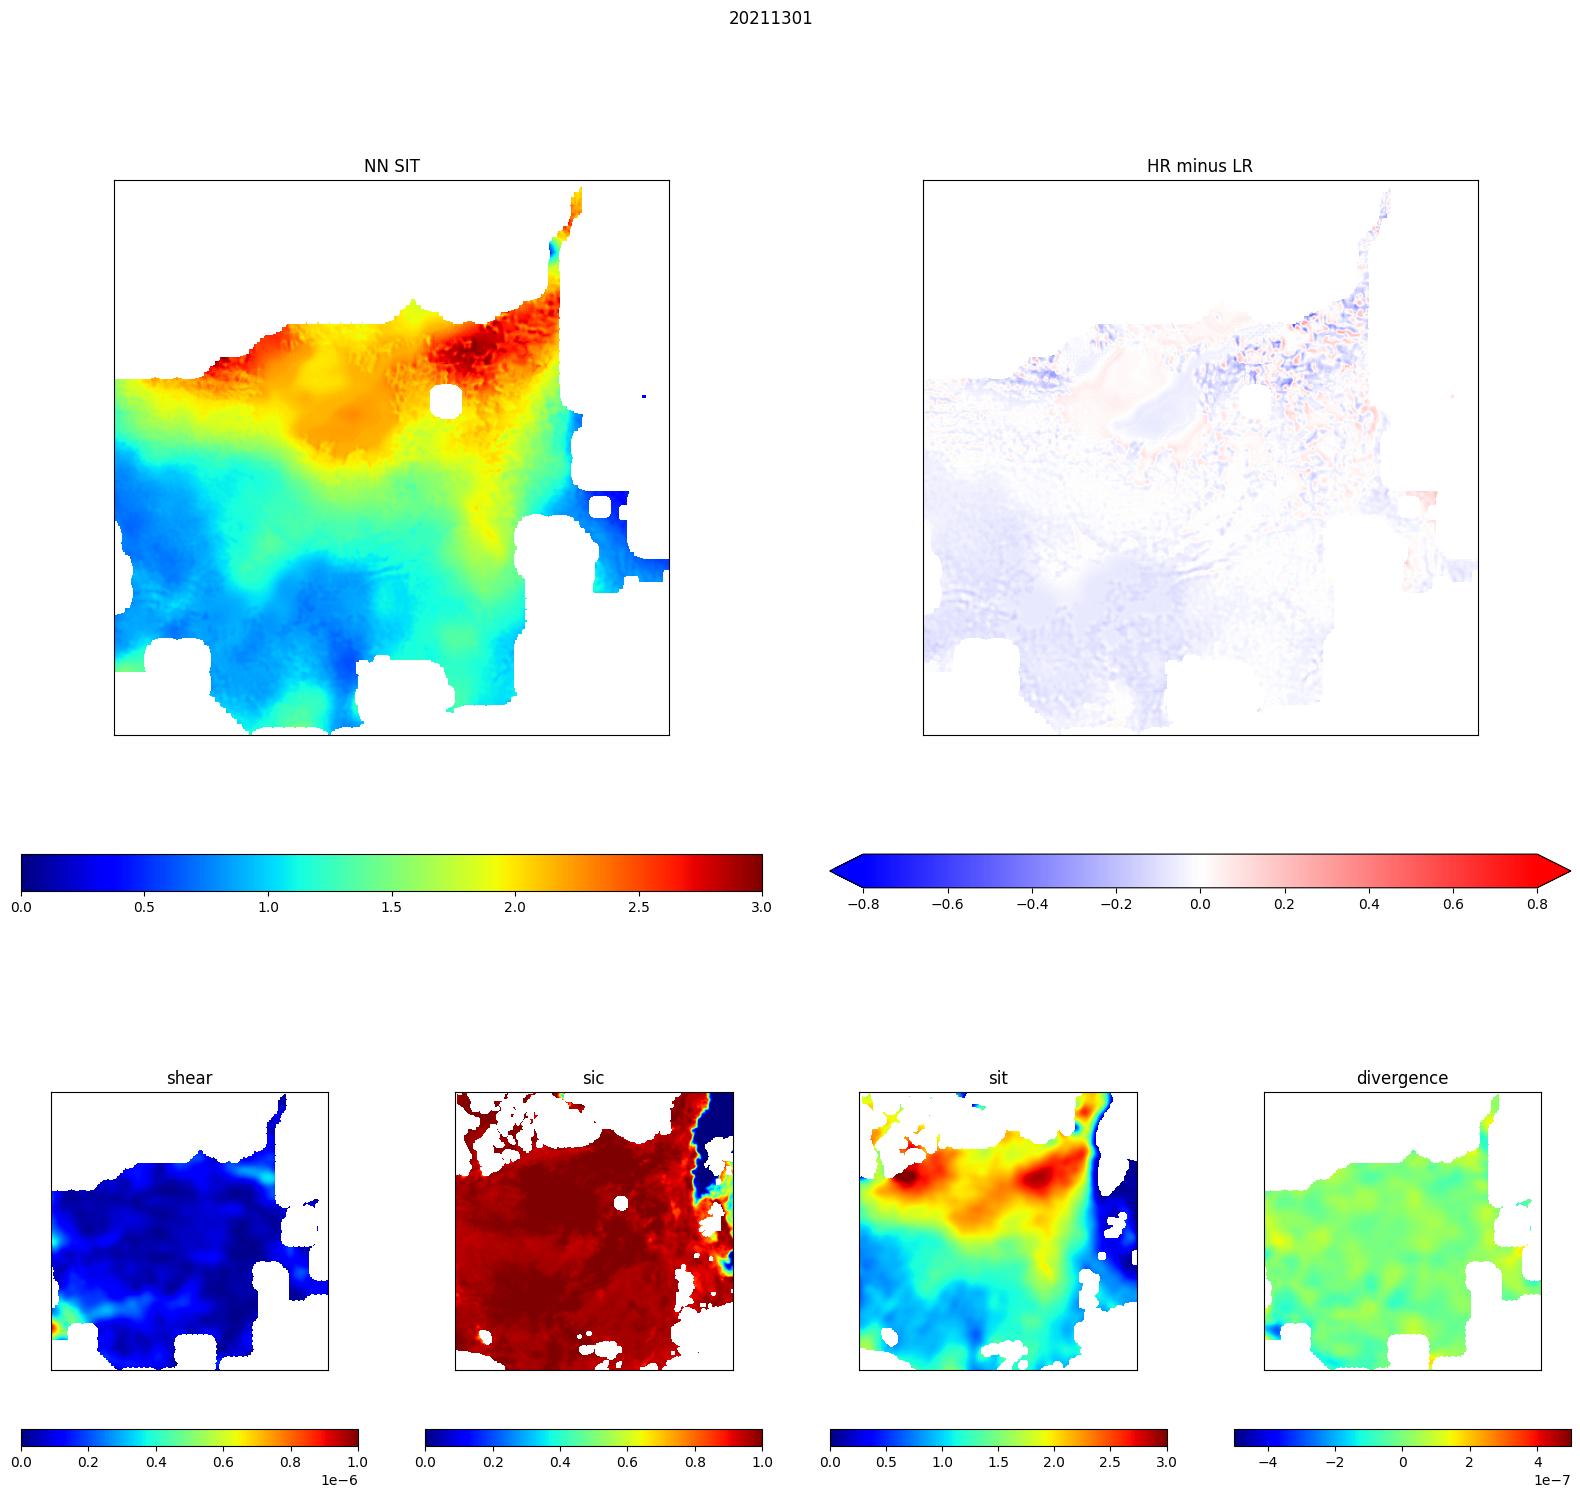

In [13]:
# Plot
colnames = [mod2sat[c] for c in exp_dict['colnames']]
nc = len(colnames)

for file in tqdm(lfiles[indx]):
    date = file[dateind]
    fname = dsat['timname'].format(date=date)
    Xim = np.load(os.path.join(dsat['path'],fname))
    fname = dsat['outname'].format(date=date)
    if os.path.isfile(os.path.join(dsat['path'],fname)):
        y2_pred = np.load(os.path.join(dsat['path'],fname))
    else:
        continue
    fig = plt.figure(figsize=(5*nc,17))

    gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[2, 1])

    for ic, c in enumerate(colnames):
        ax = fig.add_subplot(gs[1,ic])
        vmin, vmax = lims_sat[c]
        co=ax.imshow(Xim[0,...,ic], cmap='jet', vmin=vmin, vmax=vmax)
        fig.colorbar(co, ax=ax, orientation='horizontal')
        clean_ax([ax])
        ax.set_xlim((200,700))
        ax.set_ylim((200,700))
        ax.set_title(c)
    ax = fig.add_subplot(gs[0,:2])
    vmin, vmax = lims_sat['sit']
    co=ax.imshow(y2_pred, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_xlim((200,700))
    ax.set_ylim((200,700))
    ax.set_title('NN SIT')
    clean_ax([ax])
    fig.colorbar(co, ax=ax, orientation='horizontal')

    ax = fig.add_subplot(gs[0,2:4])
    vmin, vmax = -.8,.8
    ih = colnames.index('sit')
    co=ax.imshow(y2_pred-Xim[0,...,ih], cmap='bwr', vmin=vmin, vmax=vmax)
    ax.set_xlim((200,700))
    ax.set_ylim((200,700))
    ax.set_title('HR minus LR')
    clean_ax([ax])
    
    
    fig.colorbar(co, ax=ax, orientation='horizontal',extend='both')
    fig.suptitle(date)
    plt.show()
    